In [1]:
import sys
from pathlib import Path

import pandas as pd
from humanize import naturaldelta
from IPython.display import Markdown, display

sys.path.insert(0, "..")
from runner.utils import (
    compute_summary_results,
    display_speedups,
    load_benchmark_metadata,
    plot_runtime_slowdowns,
    plot_solver_scaling_by_bucket,
    plot_solver_scaling_by_bucket_scatter_only,
    plot_speedup_vs_constraints,
    plot_speedup_vs_variables,
    plot_summary_results,
    print_sgm_tables_per_bucket,
)

In [2]:
# If a util function was modified, use this cell to reload it without having to restart the kernel
%run ../runner/utils.py

### Util to load results from older runs

In [3]:
# Use this function for 20251128 and 20251201 since those runs were before we started recording `VM Zone`, which is required by utils.load_results
def load_results(folder: str | list[str]):
    """Loads all CSV files in `folder`. Returns the results and variability dataframes."""
    folders = folder if isinstance(folder, list) else [folder]
    csv_files = [p for f in folders for p in Path(f).glob("*.csv")]
    results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)

    # Remove reference benchmark
    reference_results = results.query('Benchmark == "reference-benchmark"')
    results = results.query('Benchmark != "reference-benchmark"').copy()

    # Find the variability of each VM
    variability = reference_results.groupby(["Hostname", "Run ID"]).agg(
        {"Runtime (s)": ["count", "min", "max", "std", "mean"]}
    )
    variability["std %"] = (
        variability[("Runtime (s)", "std")] * 100 / variability[("Runtime (s)", "mean")]
    )

    # Print some basic stats
    results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
    results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
    print(
        f"Found {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
    )
    return results, variability

## Download logs & Results

Results were downloaded by running the following command on the root directory of this repository:
```
gsutil -m rsync -r gs://solver-benchmarks/logs ./runner/logs/ && gsutil -m rsync -r gs://solver-benchmarks-restricted/logs ./runner/logs/  && gsutil -m rsync -r gs://solver-benchmarks/results ./results/gcp-results/
```
Then, the cells in the next section were run to clean, check, and analyze results.

## Analysis of the results

### Performance of HiPO variants on v1 PyPSA benchmarks (also used in HiPO paper)

> <!--Run ID: `20251128-test-hipo`-->

In [4]:
results, variability = load_results(["../results/gcp-results/20251128-test-hipo/"])

Found 24 records, 8 benchmark instances


In [5]:
# with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
#     hipo_benchmarks = yaml.safe_load(f)

# Since the above file was local on my laptop, I hardcoded the values here:
num_var_data = {
    "pypsa-eur-elec-op-7-1h": 1646661,
    "pypsa-eur-elec-trex-7-1h": 1646674,
    "pypsa-eur-elec-op-8-1h": 1830590,
    "pypsa-eur-elec-trex-8-1h": 1830602,
    "pypsa-eur-elec-op-9-1h": 2040798,
    "pypsa-eur-elec-trex-9-1h": 2040811,
    "pypsa-eur-elec-op-10-1h": 2251004,
    "pypsa-eur-elec-trex-10-1h": 2251019,
}

In [6]:
import numpy as np
import pandas as pd

# Filter HiPO runs 
hipo_results = results[results["Solver"].str.contains("highs-hipo")].copy()

# Pivot runtimes 
speedup_df = (
    hipo_results.pivot_table(
        index="bench-size",
        columns="Solver",
        values="Runtime (s)",
        aggfunc="first",
    )
    .reset_index()
)

# Map number of variables
speedup_df["num-vars"] = speedup_df["bench-size"].map(num_var_data)

# Pivot status (kept separate, no mixing with speedup logic) 
status_df = (
    hipo_results.pivot_table(
        index="bench-size",
        columns="Solver",
        values="Status",
        aggfunc="first",
    )
    .reset_index()
)

# Merge status into main df (optional but cleaner)
speedup_df = speedup_df.merge(
    status_df,
    on="bench-size",
    suffixes=("", "_status"),
    how="left",
)

#  Rename runtime columns
speedup_df = speedup_df.rename(
    columns={
        "highs-hipo-ipm": "hipo-ipm-time",
        "highs-hipo-64": "hipo-64-time",
        "highs-hipo-no2hop": "hipo-no2hop-time",
        "highs-hipo-ipm_status": "hipo-ipm-status",
        "highs-hipo-64_status": "hipo-64-status",
        "highs-hipo-no2hop_status": "hipo-no2hop-status",
    }
)

# Compute speedups (purely numerical logic)
speedup_df["hipo-64-speedup"] = np.where(
    speedup_df["hipo-64-time"] > 0,
    speedup_df["hipo-ipm-time"] / speedup_df["hipo-64-time"],
    np.nan,
)

speedup_df["hipo-no2hop-speedup"] = np.where(
    speedup_df["hipo-no2hop-time"] > 0,
    speedup_df["hipo-ipm-time"] / speedup_df["hipo-no2hop-time"],
    np.nan,
)

# Sorting
speedup_df = speedup_df.sort_values("num-vars")

# Pretty display dataframe
display_df = pd.DataFrame(speedup_df["bench-size"])
display_df["num-vars"] = speedup_df["num-vars"].apply(lambda x: f"{x:,.0f}")

display_df["hipo-ipm-time"] = speedup_df["hipo-ipm-time"].apply(
    lambda x: naturaldelta(x) if pd.notna(x) else "-"
)
display_df["hipo-64-time"] = speedup_df["hipo-64-time"].apply(
    lambda x: naturaldelta(x) if pd.notna(x) else "-"
)
display_df["hipo-no2hop-time"] = speedup_df["hipo-no2hop-time"].apply(
    lambda x: naturaldelta(x) if pd.notna(x) else "-"
)

display_df["hipo-64-speedup"] = speedup_df["hipo-64-speedup"].apply(
    lambda x: f"{x:.1f}x" if pd.notna(x) else "-"
)
display_df["hipo-no2hop-speedup"] = speedup_df["hipo-no2hop-speedup"].apply(
    lambda x: f"{x:.1f}x" if pd.notna(x) else "-"
)

display_df = display_df.rename(
    columns={
        "bench-size": "Benchmark",
        "num-vars": "Num. variables",
        "hipo-ipm-time": "HiPO IPM runtime",
        "hipo-64-time": "HiPO 64 runtime",
        "hipo-no2hop-time": "HiPO no-2-hop runtime",
        "hipo-64-speedup": "HiPO 64 vs IPM speedup",
        "hipo-no2hop-speedup": "HiPO no-2-hop vs IPM speedup",
    }
)

display_df.style.hide(axis="index")

Benchmark,Num. variables,HiPO IPM runtime,HiPO 64 runtime,HiPO no-2-hop runtime,HiPO 64 vs IPM speedup,HiPO no-2-hop vs IPM speedup
pypsa-eur-elec-op-7-1h,"1,646,661",4 hours,3 hours,28 minutes,1.2x,8.4x
pypsa-eur-elec-trex-7-1h,"1,646,674",4 hours,2 hours,29 minutes,1.9x,9.1x
pypsa-eur-elec-op-8-1h,"1,830,590",5 hours,3 hours,39 minutes,1.8x,7.7x
pypsa-eur-elec-trex-8-1h,"1,830,602",6 hours,3 hours,37 minutes,2.3x,10.3x
pypsa-eur-elec-op-9-1h,"2,040,798",6 hours,3 hours,34 minutes,2.2x,11.5x
pypsa-eur-elec-trex-9-1h,"2,040,811",7 hours,3 hours,42 minutes,2.3x,10.6x
pypsa-eur-elec-op-10-1h,"2,251,004",7 hours,2 hours,28 minutes,2.9x,14.7x
pypsa-eur-elec-trex-10-1h,"2,251,019",9 hours,5 hours,52 minutes,1.8x,10.2x


In [7]:
print(speedup_df[["bench-size", "num-vars"]].to_csv(index=False))

bench-size,num-vars
pypsa-eur-elec-op-7-1h,1646661
pypsa-eur-elec-trex-7-1h,1646674
pypsa-eur-elec-op-8-1h,1830590
pypsa-eur-elec-trex-8-1h,1830602
pypsa-eur-elec-op-9-1h,2040798
pypsa-eur-elec-trex-9-1h,2040811
pypsa-eur-elec-op-10-1h,2251004
pypsa-eur-elec-trex-10-1h,2251019



### Performance scaling of HiPO on a PyPSA-DE benchmark (pypsa-de-elec, no transmission expansion)
><!--Run ID: `20251219-pypsa-sizes`-->

In [8]:
results, variability = load_results(["../results/gcp-results/20251219-pypsa-sizes//"])

# Correct the bench-size-size bug
results["Benchmark"] = results.apply(
    lambda r: r["Benchmark"][: -len(r["Size"]) - 1]
    if r["Benchmark"].endswith(r["Size"])
    else r["Benchmark"],
    axis=1,
)
results["bench-size"] = results["Benchmark"] + "-" + results["Size"]

Found 33 records, 11 benchmark instances


In [9]:
# Load benchmark metadata (indexed by full bench-size)
new_pypsa_benchs = load_benchmark_metadata("../benchmarks/pypsa/metadata.yaml")

In [10]:
print("Runtime and relative speedup for HiGHS variants \n")
display_speedups(results, new_pypsa_benchs)

Runtime and relative speedup for HiGHS variants 



ValueError: Missing Num. variables for:
pypsa-de-elec-10-12h
pypsa-de-elec-20-12h
pypsa-de-elec-20-24h
pypsa-de-elec-20-3h
pypsa-de-elec-50-12h
pypsa-de-elec-50-24h

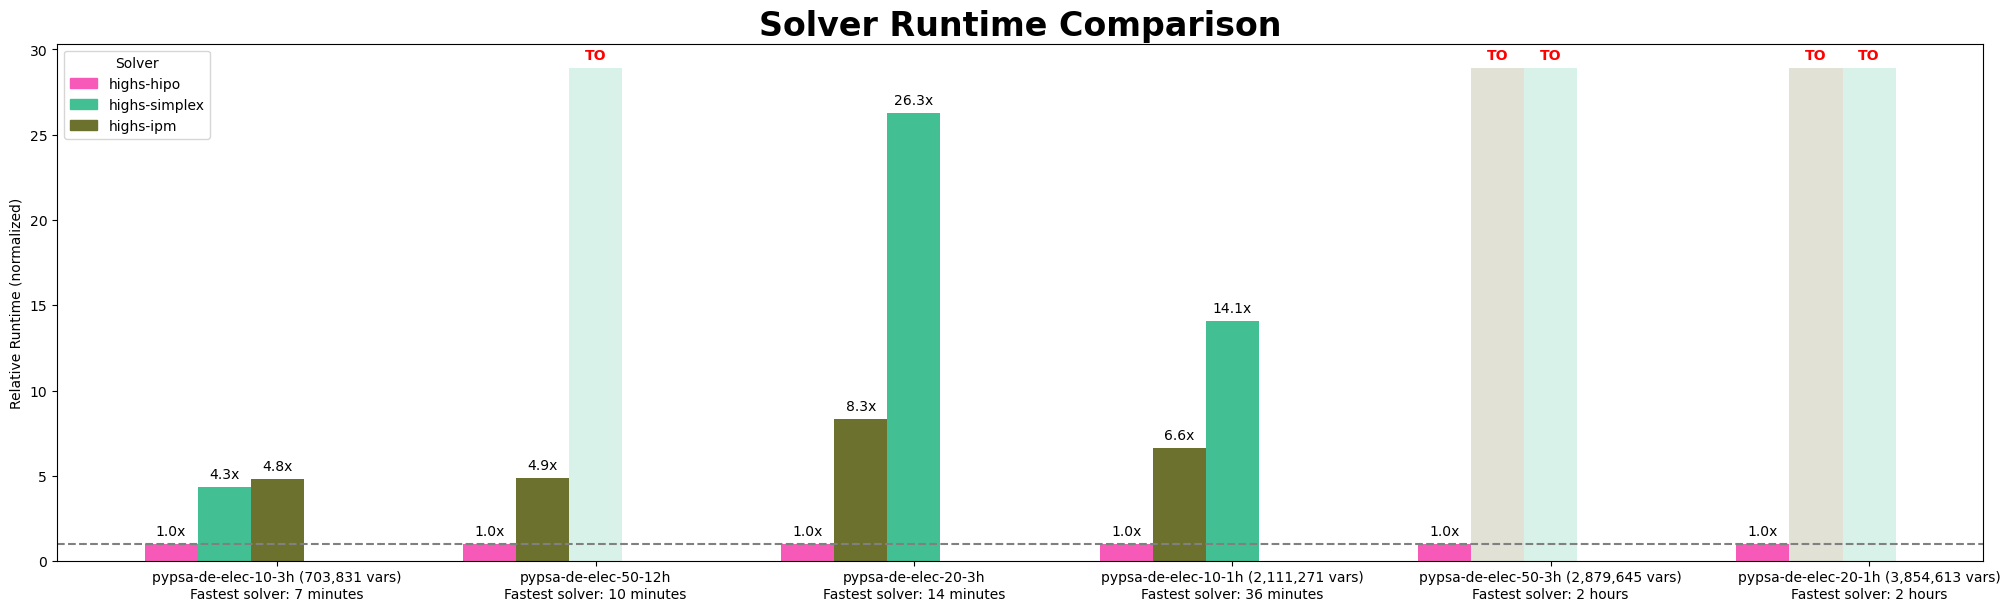

In [16]:
# Benchmarks to plot
to_plot = {
    "pypsa-de-elec-10-3h",
    "pypsa-de-elec-50-12h",
    "pypsa-de-elec-20-3h",
    "pypsa-de-elec-10-1h",
    "pypsa-de-elec-50-3h",
    "pypsa-de-elec-20-1h",
}

# Filter results
to_plot_df = results.loc[results["bench-size"].isin(to_plot)].copy()


# Safe label builder (NO map, NO NaN)
def make_label(b):
    if b in new_pypsa_benchs.index:
        return f"{b} ({new_pypsa_benchs.loc[b, 'Num. variables']:,.0f} vars)"
    return b


# plot_runtime_slowdowns uses "bench-size" for x-axis
# overwrite ONLY for plotting
to_plot_df["bench-size"] = to_plot_df["bench-size"].apply(make_label)

# Plot
plot_runtime_slowdowns(to_plot_df, figsize=(20, 6))

### Performance of HiPO on new PyPSA-DE benchmarks
><!--Run ID: `20251227-new-pypsa`-->

In [17]:
results, variability = load_results(
    ["../results/gcp-results/20251227-new-pypsa/", "../results/partial-results/"]
)

Found 213 records, 19 benchmark instances


In [18]:
print("HiGHS variants runtime and relative speedup\n")
display(display_speedups(results, new_pypsa_benchs))

HiGHS variants runtime and relative speedup



Benchmark,Num. variables,Simplex time,IPX time,HiPO time,IPX vs Simplex speedup,HiPO vs Simplex speedup
pypsa-eur-elec-50-24h,443333,TO,14 minutes,17 minutes,4.3x,3.6x
pypsa-de-elec-10-3h,703831,54 minutes,32 minutes,6 minutes,1.7x,8.8x
pypsa-de-elec-dfp-10-3h,703831,TO,41 minutes,8 minutes,1.5x,7.3x
pypsa-de-elec-trex_copt-10-3h,703869,TO,TO,9 minutes,TO,6.6x
pypsa-de-elec-trex_copt-dfp-10-3h,703869,TO,TO,9 minutes,TO,6.7x
pypsa-de-elec-trex_vopt-10-3h,703869,TO,an hour,11 minutes,1.0x,5.4x
pypsa-de-elec-trex_vopt-dfp-10-3h,703869,TO,TO,TO,TO,TO
pypsa-eur-elec-100-24h,841037,TO,OOM,OOM,OOM,OOM
pypsa-eur-elec-50-12h,886078,TO,OOM,OOM,OOM,OOM
pypsa-eur-elec-100-12h,1680902,TO,5 hours,an hour,4.6x,17.9x


### Performance of HiPO on the v2 benchmark set
Many Run IDs..

In [19]:
results = pd.read_csv("../results/benchmark_results_hipo.csv")
results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
print(
    f"Loaded {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
)
benchmarks_df = load_benchmark_metadata()

Loaded 2790 records, 213 benchmark instances


### Main Results table / plot

In [20]:
# Add benchmark metadata (size category, problem class, realistic) to the results
results_extended = results.merge(
    benchmarks_df[["Size", "Realistic", "Problem class"]].rename(
        columns={"Size": "Size Category"}
    ),
    left_on="bench-size",
    right_index=True,
    how="left",
)

# Drop old results; only keep the latest solver version as given by Solver Release Year
max_years = results_extended.groupby("Solver")["Solver Release Year"].max()
print("Before dropping:", results_extended.shape)
results_extended = results_extended[
    results_extended["Solver Release Year"] == results_extended["Solver"].map(max_years)
]
print("After dropping:", results_extended.shape)

# Drop MILPs, as we only ran HiPO on LPs
results_extended = results_extended.query("`Problem class` == 'LP'")

# Compute summary results
summary_df_1 = compute_summary_results(results_extended)
summary_df_2 = compute_summary_results(
    results_extended.query("Realistic == True"), category_suffix=" & Realistic"
)
summary_df = pd.concat([summary_df_1, summary_df_2], ignore_index=True)

# For each Class & Category, rank by SGM Runtime and display table
for (cls, cat), group in summary_df.groupby(["Class", "Category"]):
    group = group.sort_values("SGM Runtime").reset_index(drop=True)
    group["Rank"] = group.index + 1
    min_sgm = group["SGM Runtime"].min()
    group["SGM Runtime"] = group["SGM Runtime"].apply(
        lambda x: f"{x / min_sgm:.1f} ({x:.1f})"
    )
    display(Markdown(f"### {cls} – {cat}"))
    display(
        group[["Rank", "Solver", "Solved Instances", "SGM Runtime"]].style.hide(
            axis="index"
        )
    )

Before dropping: (2790, 26)
After dropping: (1270, 26)


### LP – Large

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,88% (52/59),1.0 (1851.6)
2,highs-hipo-1.12.0-hipo,53% (31/59),12.2 (22627.6)
3,highs-ipm-1.12.0-hipo,44% (26/59),25.3 (46768.0)
4,highs-1.12.0,19% (11/59),39.4 (72987.8)
5,cbc-2.10.12,2% (1/59),45.9 (84988.8)
6,scip-10.0.0,0% (0/59),46.7 (86400.0)


### LP – Large & Realistic

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,95% (42/44),1.0 (1518.3)
2,highs-hipo-1.12.0-hipo,43% (19/44),17.5 (26530.4)
3,highs-ipm-1.12.0-hipo,39% (17/44),30.1 (45767.1)
4,highs-1.12.0,14% (6/44),49.8 (75668.5)
5,cbc-2.10.12,2% (1/44),55.7 (84513.0)
6,scip-10.0.0,0% (0/44),56.9 (86400.0)


### LP – Medium

Rank,Solver,Solved Instances,SGM Runtime
1,highs-hipo-1.12.0-hipo,86% (57/66),1.0 (151.7)
2,highs-ipm-1.12.0-hipo,83% (55/66),1.1 (170.8)
3,gurobi-13.0.0,79% (52/66),1.2 (185.7)
4,highs-1.12.0,64% (42/66),1.8 (270.7)
5,cbc-2.10.12,52% (34/66),3.2 (484.8)
6,scip-10.0.0,55% (36/66),3.9 (585.0)
7,glpk-5.0,33% (22/66),10.9 (1654.8)


### LP – Medium & Realistic

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,100% (15/15),1.0 (33.7)
2,highs-1.12.0,87% (13/15),1.8 (61.3)
3,highs-ipm-1.12.0-hipo,67% (10/15),4.0 (133.4)
4,highs-hipo-1.12.0-hipo,73% (11/15),4.6 (154.2)
5,scip-10.0.0,80% (12/15),7.4 (249.9)
6,cbc-2.10.12,33% (5/15),22.9 (773.6)
7,glpk-5.0,7% (1/15),76.2 (2567.6)


### LP – Small

Rank,Solver,Solved Instances,SGM Runtime
1,highs-1.12.0,88% (7/8),1.0 (12.2)
2,gurobi-13.0.0,88% (7/8),1.0 (12.5)
3,cbc-2.10.12,88% (7/8),1.1 (13.0)
4,scip-10.0.0,88% (7/8),1.2 (15.1)
5,highs-ipm-1.12.0-hipo,75% (6/8),2.9 (35.9)
6,highs-hipo-1.12.0-hipo,75% (6/8),3.0 (37.0)
7,glpk-5.0,50% (4/8),16.2 (198.1)


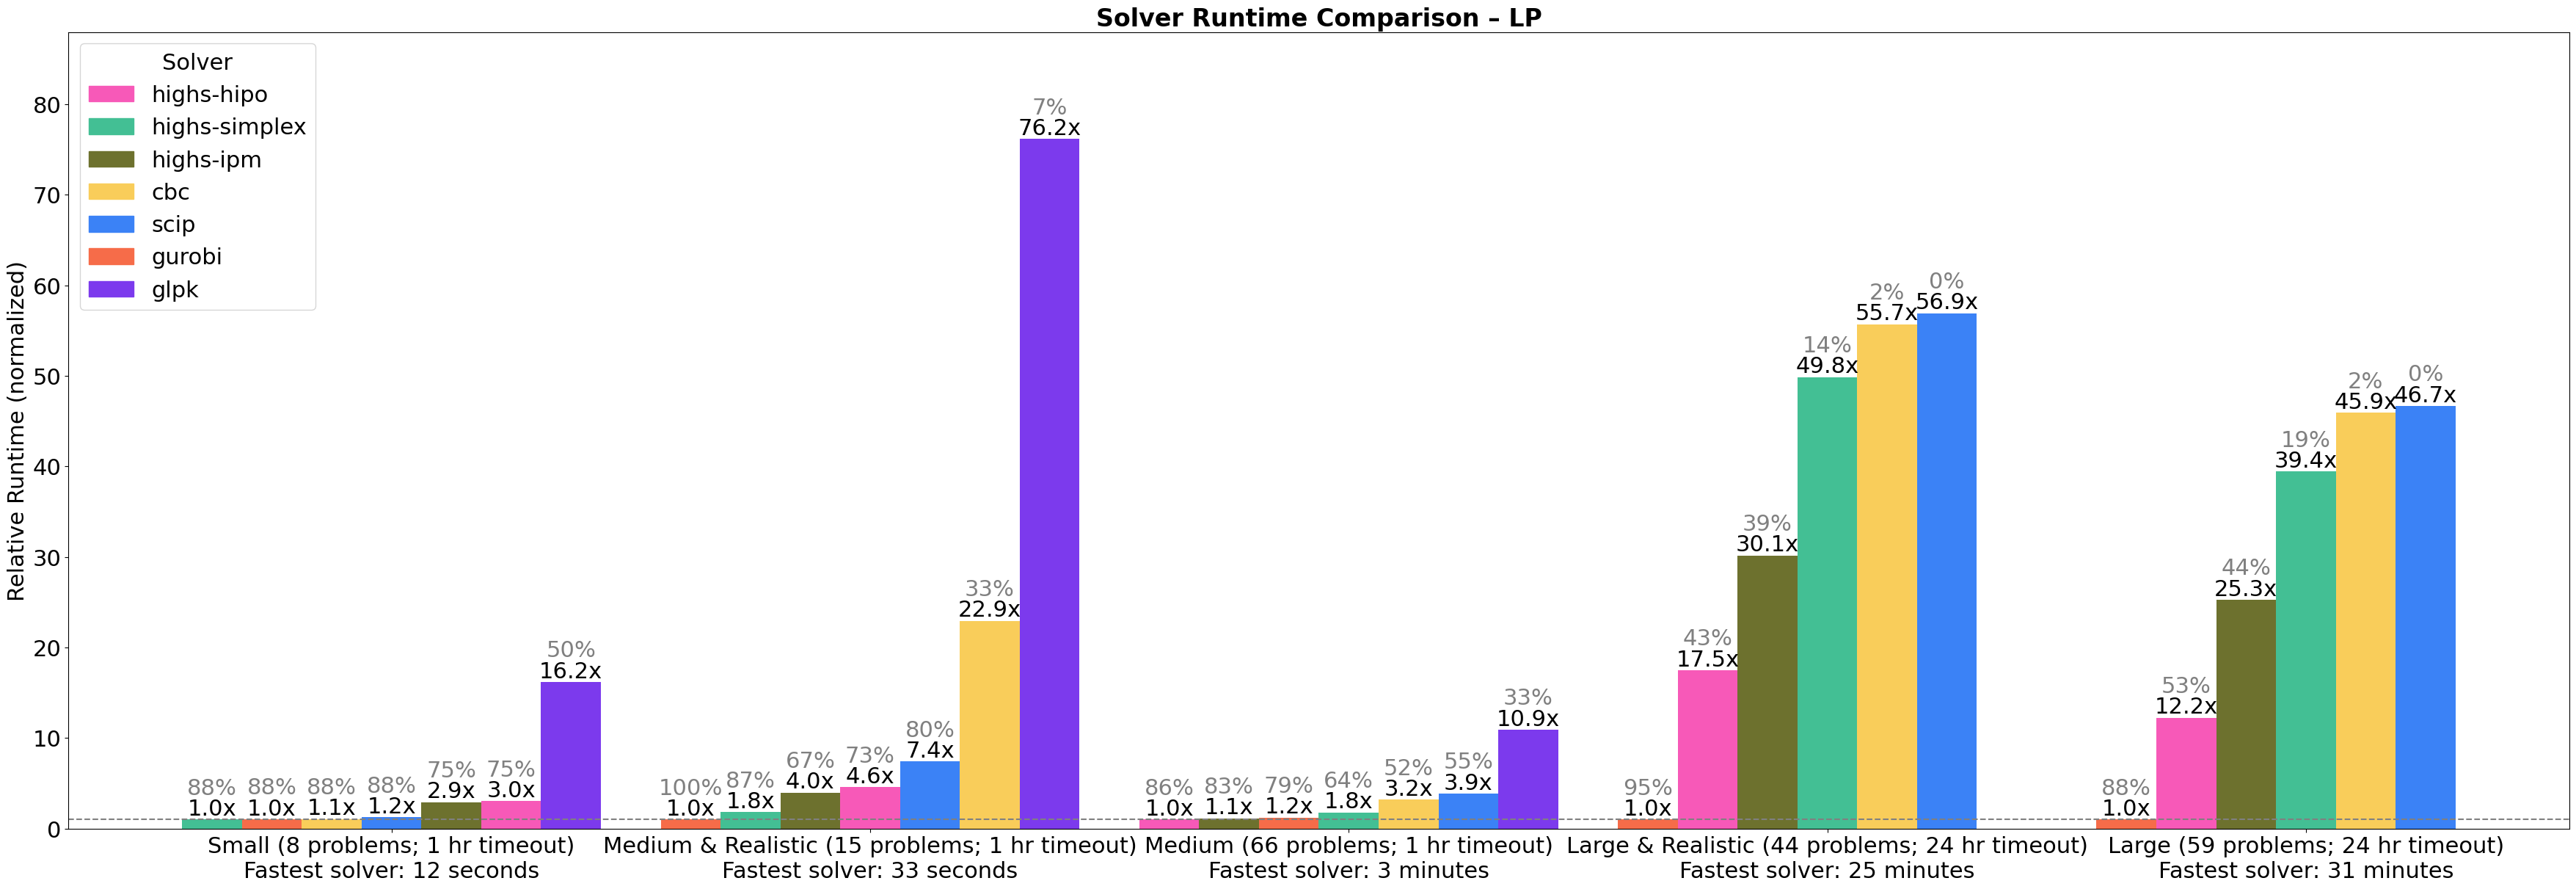

In [21]:
label_map = {
    "Small": "Small (8 problems; 1 hr timeout)",
    "Medium": "Medium (66 problems; 1 hr timeout)",
    "Medium & Realistic": "Medium & Realistic (15 problems; 1 hr timeout)",
    "Large": "Large (59 problems; 24 hr timeout)",
    "Large & Realistic": "Large & Realistic (44 problems; 24 hr timeout)",
}
plot_summary_results(summary_df, "LP", max_num_solvers=7, label_map=label_map)

### Scaling comparison

In [22]:
bench_meta = load_benchmark_metadata("../results/metadata.yaml")

meta = bench_meta.reset_index().rename(
    columns={"Benchmark": "Benchmark_clean", "Instance": "Size"}
)

# Remove duplicated columns (e.g. Size)
meta = meta.loc[:, ~meta.columns.duplicated()]

df = results.copy()

# Remove TO using status
df = df[~df["Status"].astype(str).str.contains("TO|TIME", case=False, na=False)].copy()


def clean_name(row):
    b, s = row["Benchmark"], row["Size"]
    suffix = f"-{s}"
    if isinstance(b, str) and b.endswith(suffix):
        return b[: -len(suffix)]
    return b


df["Benchmark_clean"] = df.apply(clean_name, axis=1)

# Minimum runtime per solver
pivot = df.pivot_table(
    index=["Benchmark_clean", "Size"],
    columns="Solver",
    values="Runtime (s)",
    aggfunc="min",
).reset_index()

final_with_size = pivot.merge(meta, on=["Benchmark_clean", "Size"], how="left")

solver_cols = ["gurobi", "highs", "highs-hipo", "highs-ipm"]

cols_keep = (
    ["Benchmark_clean", "Size"] + solver_cols + ["Num. variables", "Num. constraints"]
)

final_with_size = final_with_size[cols_keep]

final_with_size = final_with_size.sort_values(
    "Num. variables", ascending=True
).reset_index(drop=True)

for c in solver_cols:
    if c in final_with_size.columns:
        assert not final_with_size[c].isin([3600, 86400]).any(), (
            f"Timeout value still present in column {c}"
        )


### Scaling by size buckets

/home/user/solver-benchmark/runner/utils.py:896: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


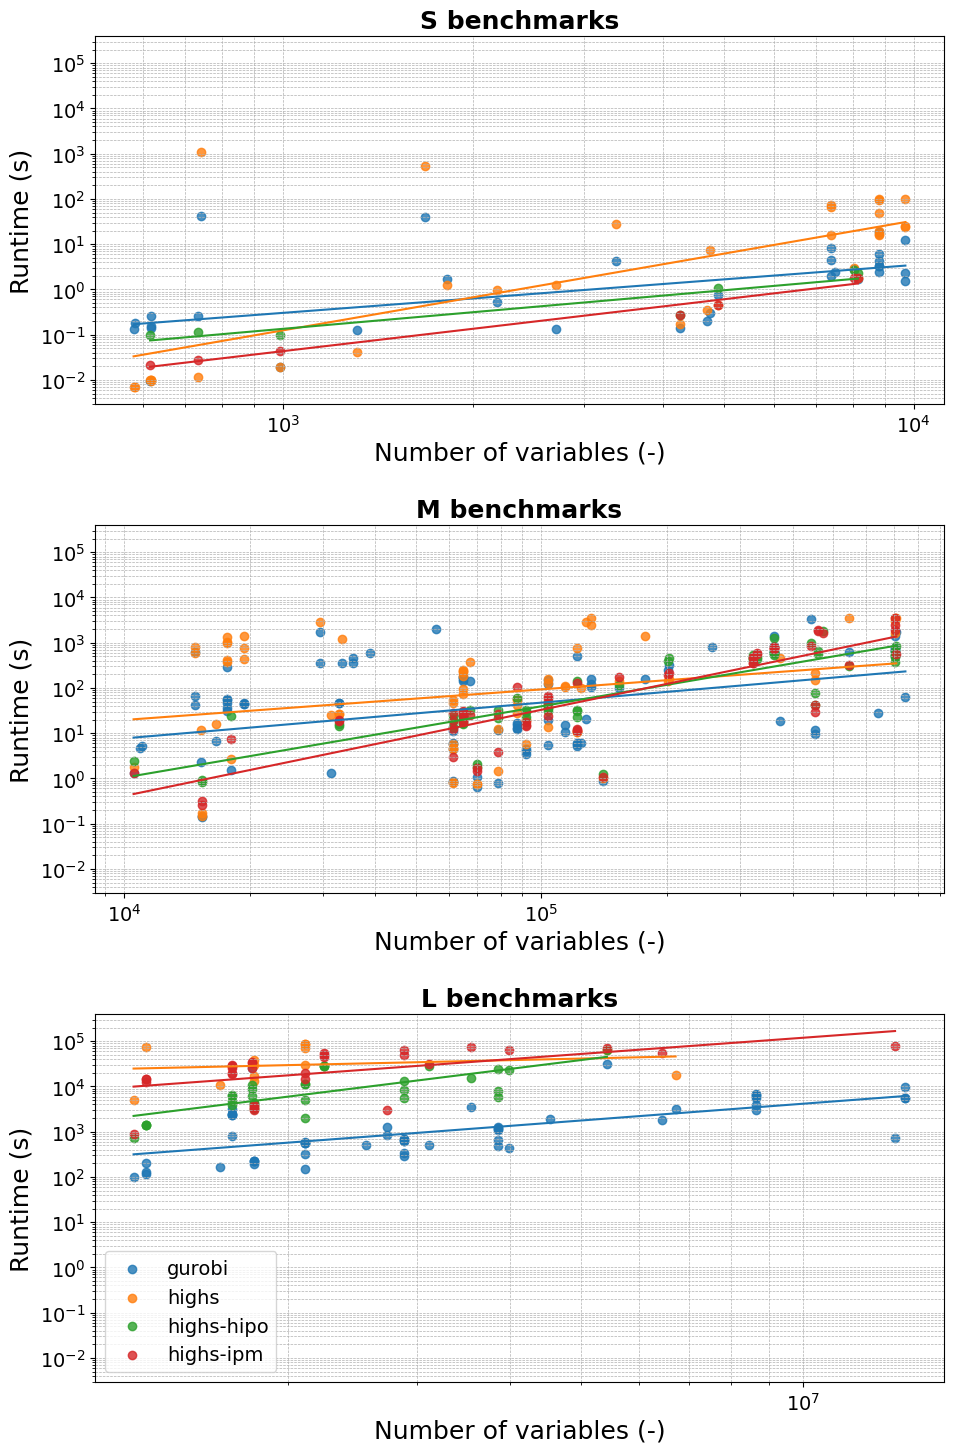

In [23]:
plot_solver_scaling_by_bucket(final_with_size)

/home/user/solver-benchmark/runner/utils.py:1162: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


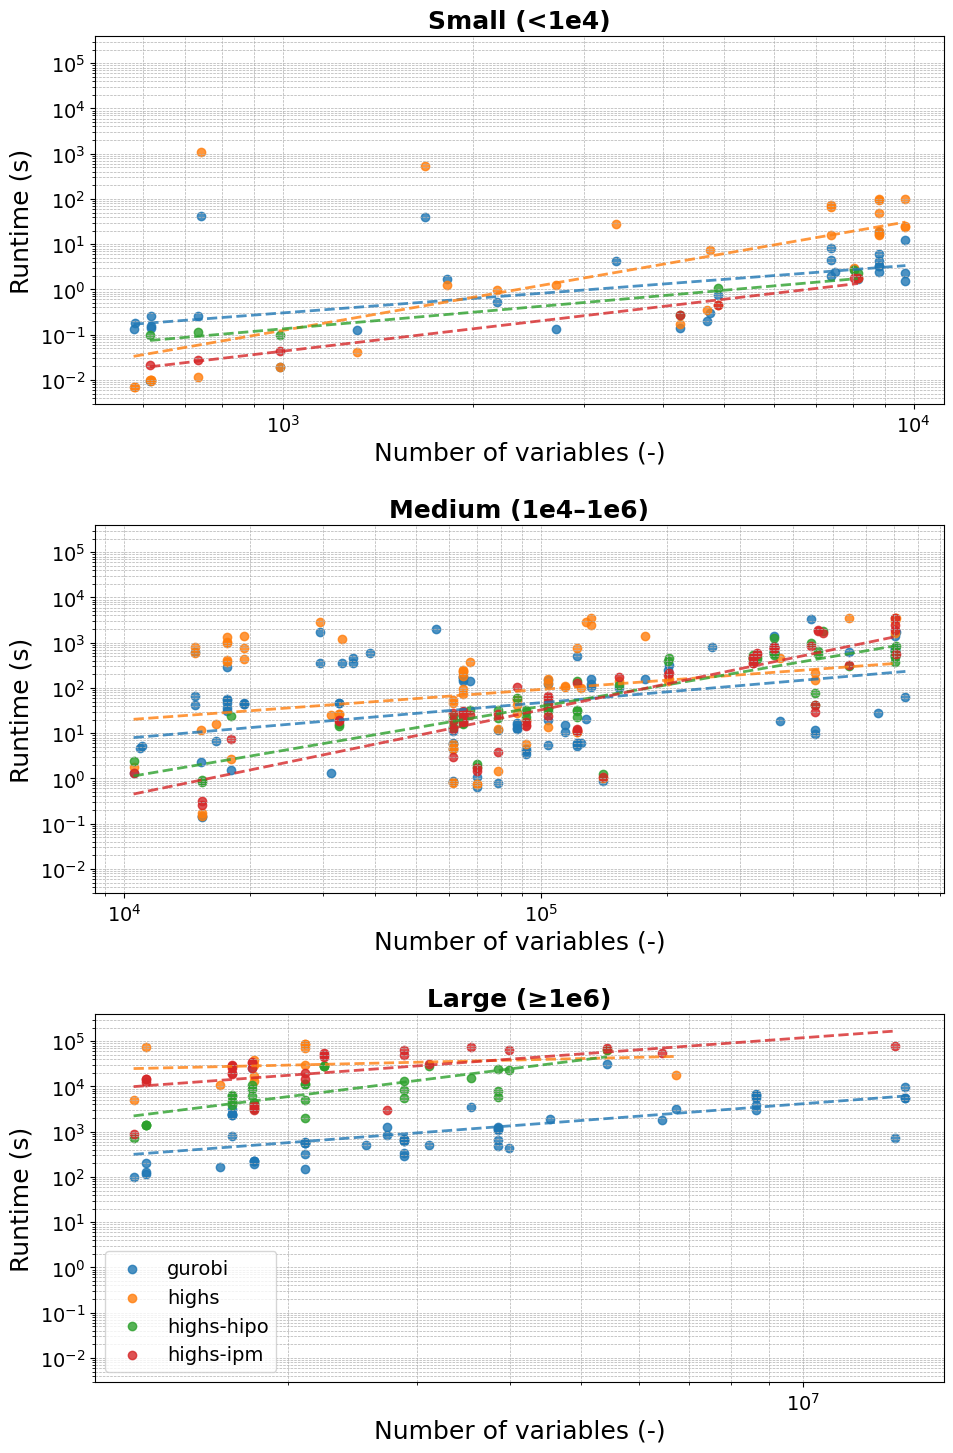

In [24]:
plot_solver_scaling_by_bucket_scatter_only(final_with_size)

### SGM tables by size bucket

In [25]:
empirical_buckets = [
    {
        "name": "Num. variables < 1e5",
        "mask": final_with_size["Num. variables"] < 1e5,
        "penalty": 3600,
    },
    {
        "name": "Num. variables 1e5 – 3e5",
        "mask": (final_with_size["Num. variables"] >= 1e5)
        & (final_with_size["Num. variables"] < 3e5),
        "penalty": 3600,
    },
    {
        "name": "Num. variables: 3e5 – 7e5",
        "mask": (final_with_size["Num. variables"] >= 3e5)
        & (final_with_size["Num. variables"] < 7e5),
        "penalty": 3600,
    },
    {
        "name": "Num. variables: > 1e6",
        "mask": final_with_size["Num. variables"] >= 1e6,
        "penalty": 86400,
    },
]

print_sgm_tables_per_bucket(final_with_size, empirical_buckets)


Num. variables < 1e5


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,0.65,79,89,88.8
HiGHS-HiPO,7.08,32,89,36.0
HiGHS-IPX,6.55,32,89,36.0
Gurobi,0.17,89,89,100.0



Num. variables 1e5 – 3e5


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,2.82,19,21,90.5
HiGHS-HiPO,5.29,12,21,57.1
HiGHS-IPX,4.61,12,21,57.1
Gurobi,0.73,21,21,100.0



Num. variables: 3e5 – 7e5


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,40.12,4,20,20.0
HiGHS-HiPO,9.56,18,20,90.0
HiGHS-IPX,10.31,18,20,90.0
Gurobi,12.76,11,20,55.0



Num. variables: > 1e6


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,1143.81,13,59,22.0
HiGHS-HiPO,374.99,32,59,54.2
HiGHS-IPX,672.08,31,59,52.5
Gurobi,25.20,54,59,91.5


In [26]:
sml_buckets = [
    {
        "name": "Small (< 1e4 variables)",
        "mask": final_with_size["Num. variables"] < 1e4,
        "penalty": 3600,
    },
    {
        "name": "Medium (1e4 – 1e6 variables)",
        "mask": (final_with_size["Num. variables"] >= 1e4)
        & (final_with_size["Num. variables"] < 1e6),
        "penalty": 3600,
    },
    {
        "name": "Large (> 1e6 variables)",
        "mask": final_with_size["Num. variables"] >= 1e6,
        "penalty": 86400,
    },
]

print_sgm_tables_per_bucket(final_with_size, sml_buckets)


Small (< 1e4 variables)


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,0.14,33,34,97.1
HiGHS-HiPO,12.41,7,34,20.6
HiGHS-IPX,12.05,7,34,20.6
Gurobi,0.03,34,34,100.0



Medium (1e4 – 1e6 variables)


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,4.36,73,104,70.2
HiGHS-HiPO,6.23,61,104,58.7
HiGHS-IPX,6.29,59,104,56.7
Gurobi,1.14,95,104,91.3



Large (> 1e6 variables)


Solver,SGM runtime (min),# solved,# total,% solved
HiGHS-Simplex,1143.81,13,59,22.0
HiGHS-HiPO,374.99,32,59,54.2
HiGHS-IPX,672.08,31,59,52.5
Gurobi,25.20,54,59,91.5


### Speedup vs num vars

/home/user/solver-benchmark/runner/utils.py:815: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


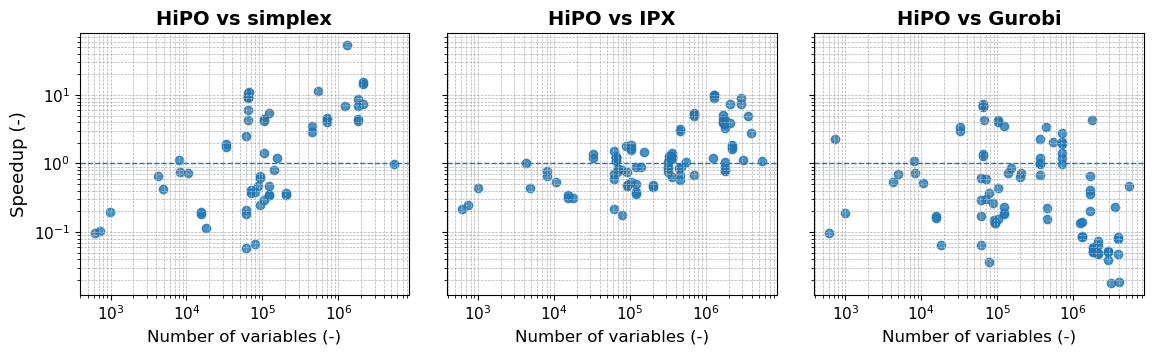

In [27]:
plot_speedup_vs_variables(
    final_with_size,
    outpath="speedup_vs_num_variables.png",
)

/home/user/solver-benchmark/runner/utils.py:991: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


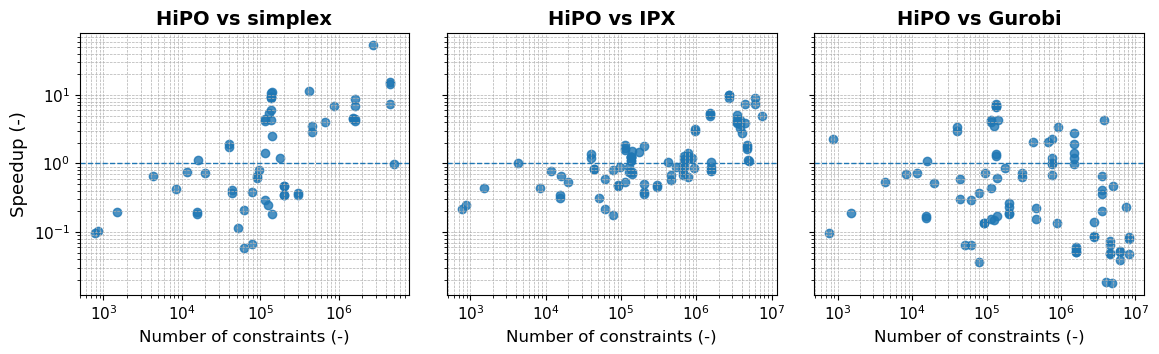

In [28]:
plot_speedup_vs_constraints(
    final_with_size,
    outpath="speedup_vs_num_constraints.png",
)

### Largest problems solvable by HiPO (and Gurobi)

In [31]:
def display_runtime_comparison(df, solver_col, solver_name):
    """
    Display a runtime comparison table vs Gurobi.
    All computations are done in MINUTES.

    Gurobi speedup (×) = solver_runtime / gurobi_runtime
      > 1  : Gurobi faster
      < 1  : Solver faster
    """

    df = df.copy()

    # Convert runtimes to minutes
    df["Gurobi runtime (min)"] = df["gurobi"] / 60
    df[f"{solver_name} runtime (min)"] = df[solver_col] / 60

    # Speedup: how many times the solver is slower than Gurobi
    df["Gurobi speedup (×)"] = (
        df[f"{solver_name} runtime (min)"] / df["Gurobi runtime (min)"]
    )

    display(
        df.rename(columns={"Benchmark_clean": "Benchmark"})[
            [
                "Benchmark",
                "Size",
                "Gurobi runtime (min)",
                f"{solver_name} runtime (min)",
                "Gurobi speedup (×)",
                "Num. variables",
                "Num. constraints",
            ]
        ]
        .style.hide(axis="index")
        .format(
            {
                "Gurobi runtime (min)": "{:.1f}",
                f"{solver_name} runtime (min)": "{:.1f}",
                "Gurobi speedup (×)": "{:.1f}×",
                "Num. variables": "{:,.0f}",
                "Num. constraints": "{:,.0f}",
            },
            na_rep="N/A",
        )
    )


display(Markdown("### Largest instances solvable by default HiGHS-simplex"))
display_runtime_comparison(
    final_with_size.query("highs.notnull()").sort_values("Num. variables").tail(5),
    solver_col="highs",
    solver_name="HiGHS-simplex",
)

display(Markdown("### Largest instances solvable by HiGHS-IPX"))
display_runtime_comparison(
    final_with_size.query("`highs-ipm`.notnull()")
    .sort_values("Num. variables")
    .tail(5),
    solver_col="highs-ipm",
    solver_name="HiGHS-IPX",
)

display(Markdown("### Largest instances solvable by HiGHS-HiPO"))
display_runtime_comparison(
    final_with_size.query("`highs-hipo`.notnull()")
    .sort_values("Num. variables")
    .tail(5),
    solver_col="highs-hipo",
    solver_name="HiGHS-HiPO",
)

### Largest instances solvable by default HiGHS-simplex

Benchmark,Size,Gurobi runtime (min),HiGHS-simplex runtime (min),Gurobi speedup (×),Num. variables,Num. constraints
pypsa-de-elec,10-1h,2.4,508.3,207.7×,"2,111,271","4,502,789"
pypsa-de-elec-trex_copt-dfp,10-1h,9.2,1431.6,155.6×,"2,111,309","4,502,865"
pypsa-de-elec-trex_vopt-dfp,10-1h,9.4,1419.5,151.3×,"2,111,309","4,502,865"
TIMES-GEO-global-netzero,31-20ts,510.4,1047.8,2.1×,"5,422,595","5,063,755"
pypsa-eur-elec,100-3h,52.6,299.0,5.7×,"6,720,092","14,064,375"


### Largest instances solvable by HiGHS-IPX

Benchmark,Size,Gurobi runtime (min),HiGHS-IPX runtime (min),Gurobi speedup (×),Num. variables,Num. constraints
pypsa-eur-elec,50-3h,58.7,1244.4,21.2×,"3,542,548","7,379,675"
SWITCH-USA-PG,26-168h,7.2,1088.4,150.5×,"3,989,071","4,022,362"
TIMES-GEO-global-netzero,31-20ts,510.4,1168.0,2.3×,"5,422,595","5,063,755"
TIMES-GEO-global-base,31-20ts,31.0,912.7,29.5×,"6,449,851","6,027,253"
SWITCH-China-open-model,32-433ts,11.9,1280.0,107.2×,"13,338,520","14,588,407"


### Largest instances solvable by HiGHS-HiPO

Benchmark,Size,Gurobi runtime (min),HiGHS-HiPO runtime (min),Gurobi speedup (×),Num. variables,Num. constraints
pypsa-de-elec-dfp,20-1h,8.0,99.9,12.4×,"3,854,613","8,208,403"
pypsa-de-elec,20-1h,10.9,131.4,12.0×,"3,854,613","8,208,403"
pypsa-de-elec-trex_copt,20-1h,19.6,410.9,20.9×,"3,854,670","8,208,517"
SWITCH-USA-PG,26-168h,7.2,387.9,53.7×,"3,989,071","4,022,362"
TIMES-GEO-global-netzero,31-20ts,510.4,1078.6,2.1×,"5,422,595","5,063,755"


### Number of problems solvable by open solvers

In [30]:
# Compute number of solvable problems by size category and solver sets
solvable_df = (
    results_extended.groupby(["Size Category", "bench-size"])
    .agg(
        solvable_any=("Status", lambda x: (x == "ok").any()),
        solvable_open=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk"]))
            ).any(),
        ),
        solvable_open_ipm=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk", "highs-ipm"]))
            ).any(),
        ),
        solvable_open_ipm_hipo=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk", "highs-ipm", "highs-hipo"]))
            ).any(),
        ),
    )
    .reset_index()
)

solvable_df = (
    solvable_df.groupby(["Size Category"])
    .agg(
        num_instances=("bench-size", "count"),
        solvable_any=("solvable_any", "sum"),
        solvable_open=("solvable_open", "sum"),
        solvable_open_ipm=("solvable_open_ipm", "sum"),
        solvable_open_ipm_hipo=("solvable_open_ipm_hipo", "sum"),
    )
    .reset_index()
)

solvable_df.sort_values("Size Category", ascending=False).style.format().hide(
    axis="index"
)

Size Category,num_instances,solvable_any,solvable_open,solvable_open_ipm,solvable_open_ipm_hipo
S,8,7,7,7,7
M,66,63,49,61,63
L,59,57,11,30,35


### TODO

In [ ]:
# TODO
# Compare: HiGHS default (simplex) vs IPX vs HiPO
# Overall number of problems solved, then breakdown in each size category, model framework, etc
# Are there clear recommendations in terms of when to use simplex vs IPX vs HiPO? E.g. PyPSA models, or infrastructure models?